# About

This is a demonstration of the difference between MC files for PID (they were selected because they have significantly different proportions of muon tracks). Thus the training and test samples should be prepared in a correct way: randomly sampled from the whole available set of files. Further the reweighting procedure is demonstrated for these different files.

In this notebook we:

* compare feature distributions between two files for different track types
* compare multidimensional distributions between two files for different track types using classifier 
* reweight first sample to the second on per-track basis and check that reweighting works well.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import numpy
import root_numpy
import os
from matplotlib import pyplot as plt

## Read the data

Take two different files:
* ANNPID.2.root
* ANNPID.13.root

In [3]:
# ! cd ../data/; wget  http://www.hep.phy.cam.ac.uk/~jonesc/lhcb/PID/ProtoParticlePIDtuples/MC/Sim09Devx/Reco15x/Dev03/ANNPID.13.root

In [4]:
branches = set(root_numpy.list_branches('../data/ANNPID.2.root', treename='ANNPID/DecayTree'))
branches = list(branches - {'piplus_OWNPV_COV_'})

In [5]:
selection = '(!HasMC || MCVertexType==1 || MCVertexType==2) && \
             (TrackLikelihood > -100.0) && \
             (TrackP > 0) && \
             (TrackPt > 0) && (abs(TrackType-3) < 0.1)'

data1 = root_numpy.root2array('../data/ANNPID.13.root', branches=branches, 
                              treename='ANNPID/DecayTree', 
                              selection=selection)
data2 = root_numpy.root2array('../data/ANNPID.2.root', branches=branches,
                              treename='ANNPID/DecayTree', 
                              selection=selection)

data1 = pandas.DataFrame(data1)
data2 = pandas.DataFrame(data2)

In [6]:
len(data1), len(data2)

(2415204, 495694)

#### Adding signal column (calasses from 0 to 5 for each particle type)

In [7]:
from utils import compute_labels_and_weights, labels_names_correspondence

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
data1['Signal'], _ = compute_labels_and_weights(data1.MCParticleType.values)
data2['Signal'], _ = compute_labels_and_weights(data2.MCParticleType.values)

## Number of tracks for each track type 

In [9]:
for signal_label, particle_name in labels_names_correspondence.items():
    print "{name:10} portions: {:1.5f} {:1.5f} \t N tracks: {n1:8} {n2:8}".format(
        numpy.mean(data1['Signal'] == signal_label),
        numpy.mean(data2['Signal'] == signal_label),
        n1=sum(data1['Signal'] == signal_label),
        n2=sum(data2['Signal'] == signal_label),
        name=particle_name,
    ) 

Ghost      portions: 0.14262 0.14210 	 N tracks:   344466    70436
Electron   portions: 0.00497 0.00500 	 N tracks:    12004     2476
Muon       portions: 0.05121 0.00792 	 N tracks:   123681     3928
Pion       portions: 0.63309 0.64104 	 N tracks:  1529050   317760
Kaon       portions: 0.10290 0.14042 	 N tracks:   248534    69607
Proton     portions: 0.06520 0.06352 	 N tracks:   157469    31487


# Compare features

ignoring in plots -999 and also ignoring long tails of distributions

In [10]:
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
from collections import OrderedDict

def compare_data_by_particle(data1, data2, features, ignored_sideband=0.01):
    kw_args = {'bins': 30, 'alpha': 0.3, 'normed': True}
    
    subsamples = OrderedDict()
    for signal_label, particle_name in labels_names_correspondence.items():
        subsamples[signal_label] = data1[data1.Signal == signal_label], data2[data2.Signal == signal_label]

    plt.figure(figsize=(28, 5 * len(features)))
    for n, feature in enumerate(features):
        val = data1[feature].values
        v_min, v_max = numpy.percentile(val[val != -999], [ignored_sideband * 100, (1. - ignored_sideband) * 100])
        v_min = numpy.floor(v_min)
        v_max = numpy.ceil(v_max)
        for signal_label, particle_name in labels_names_correspondence.items():
            plt.subplot(len(features),
                        len(labels_names_correspondence), n * len(labels_names_correspondence) + signal_label + 1)
            subsample1, subsample2 = subsamples[signal_label]
            x1, x2 = subsample1[feature].values, subsample2[feature].values
            x1 = x1[x1 != -999]
            x2 = x2[x2 != -999]            
            plt.hist(x1, range=(v_min, v_max), **kw_args)
            plt.hist(x2, range=(v_min, v_max), **kw_args)
            title = '%s: KS=%1.3f' % (
                particle_name, 
                ks_2samp(x1, x2)[0],
            )     
            plt.title(title, fontsize=12)
            plt.xlabel(feature + '\n', fontsize=12)

In [11]:
model_output = 'img/paper/'

## Acceptances:

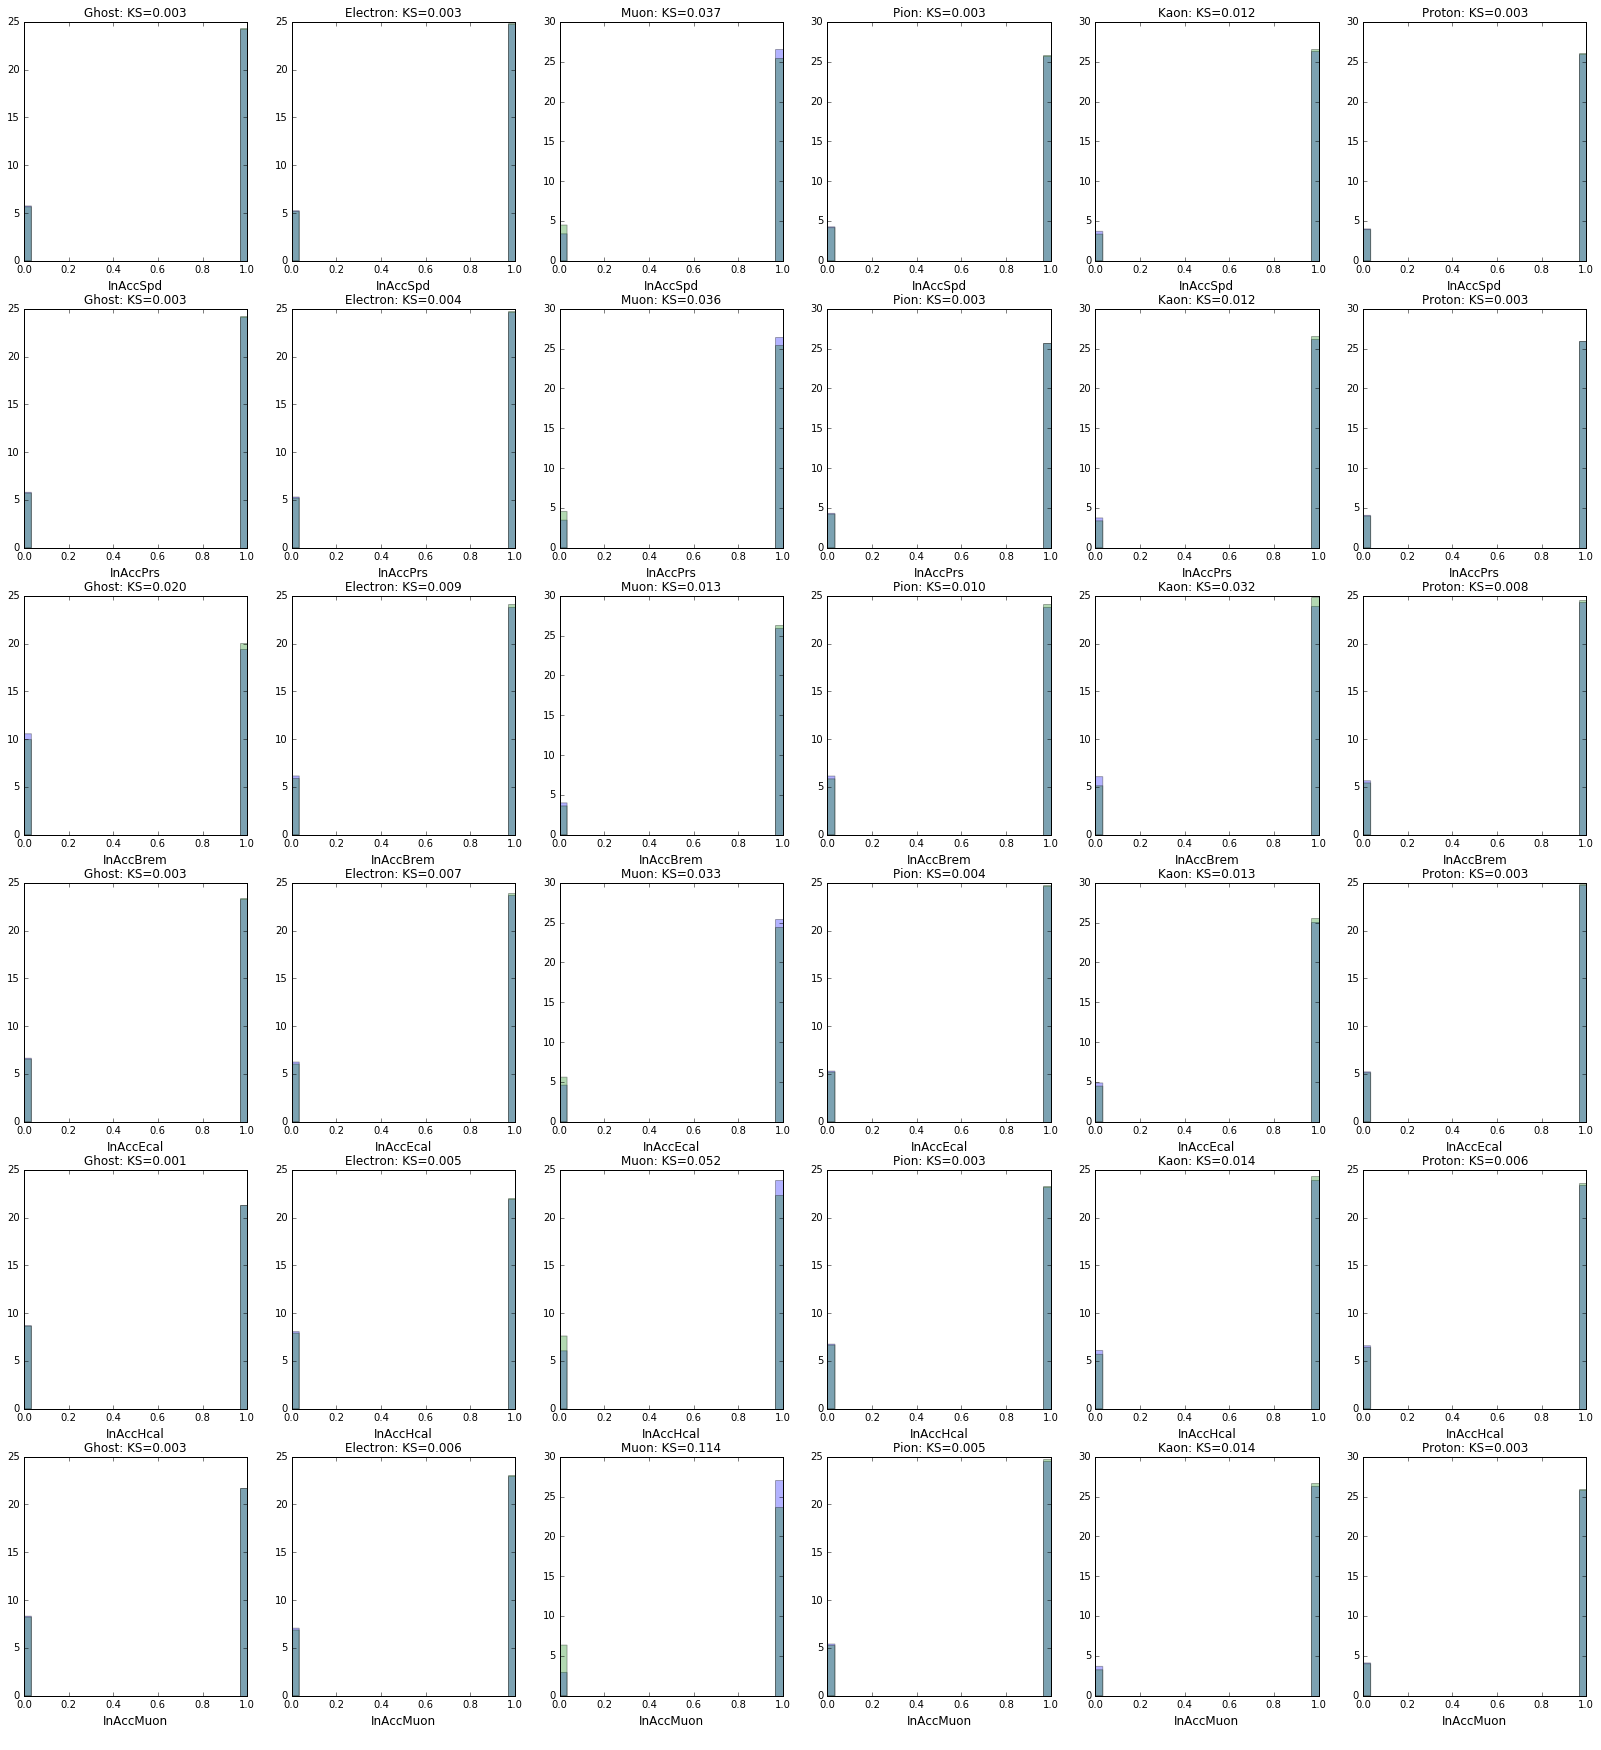

In [12]:
features_acceptance = ['InAccSpd', 'InAccPrs', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon']
compare_data_by_particle(data1, data2, features=features_acceptance)
plt.savefig(os.path.join(model_output, 'two_files_comparison_acc.pdf'), format='pdf')

## CALO features

In [13]:
features_CALO_DLL_e = ['PrsPIDe', 'BremPIDe', 'EcalPIDe', 'HcalPIDe']
features_CALO_DLL_mu  = ['EcalPIDmu', 'HcalPIDmu']
features_CALO_E = ['CaloSpdE', 'CaloPrsE', 'CaloEcalE', 'CaloHcalE']
features_CALO_neutral  = ['CaloNeutralSpd', 'CaloNeutralPrs', 'CaloNeutralEcal']
features_CALO_charged = ['CaloChargedSpd', 'CaloChargedPrs' , 'CaloChargedEcal']
features_CALO_others = ['CaloBremMatch', 'CaloElectronMatch', 'CaloTrMatch', 'CaloTrajectoryL']
features_CALO = features_CALO_others + features_CALO_charged + features_CALO_neutral + features_CALO_E + \
    features_CALO_DLL_mu + features_CALO_DLL_e

In [14]:
features_CALO_plot = [
 'CaloElectronMatch',
 'CaloTrajectoryL',
 'CaloPrsE',
 'CaloEcalE',
 'EcalPIDmu',
 'HcalPIDmu',
 'PrsPIDe',
 'EcalPIDe',
 'HcalPIDe']

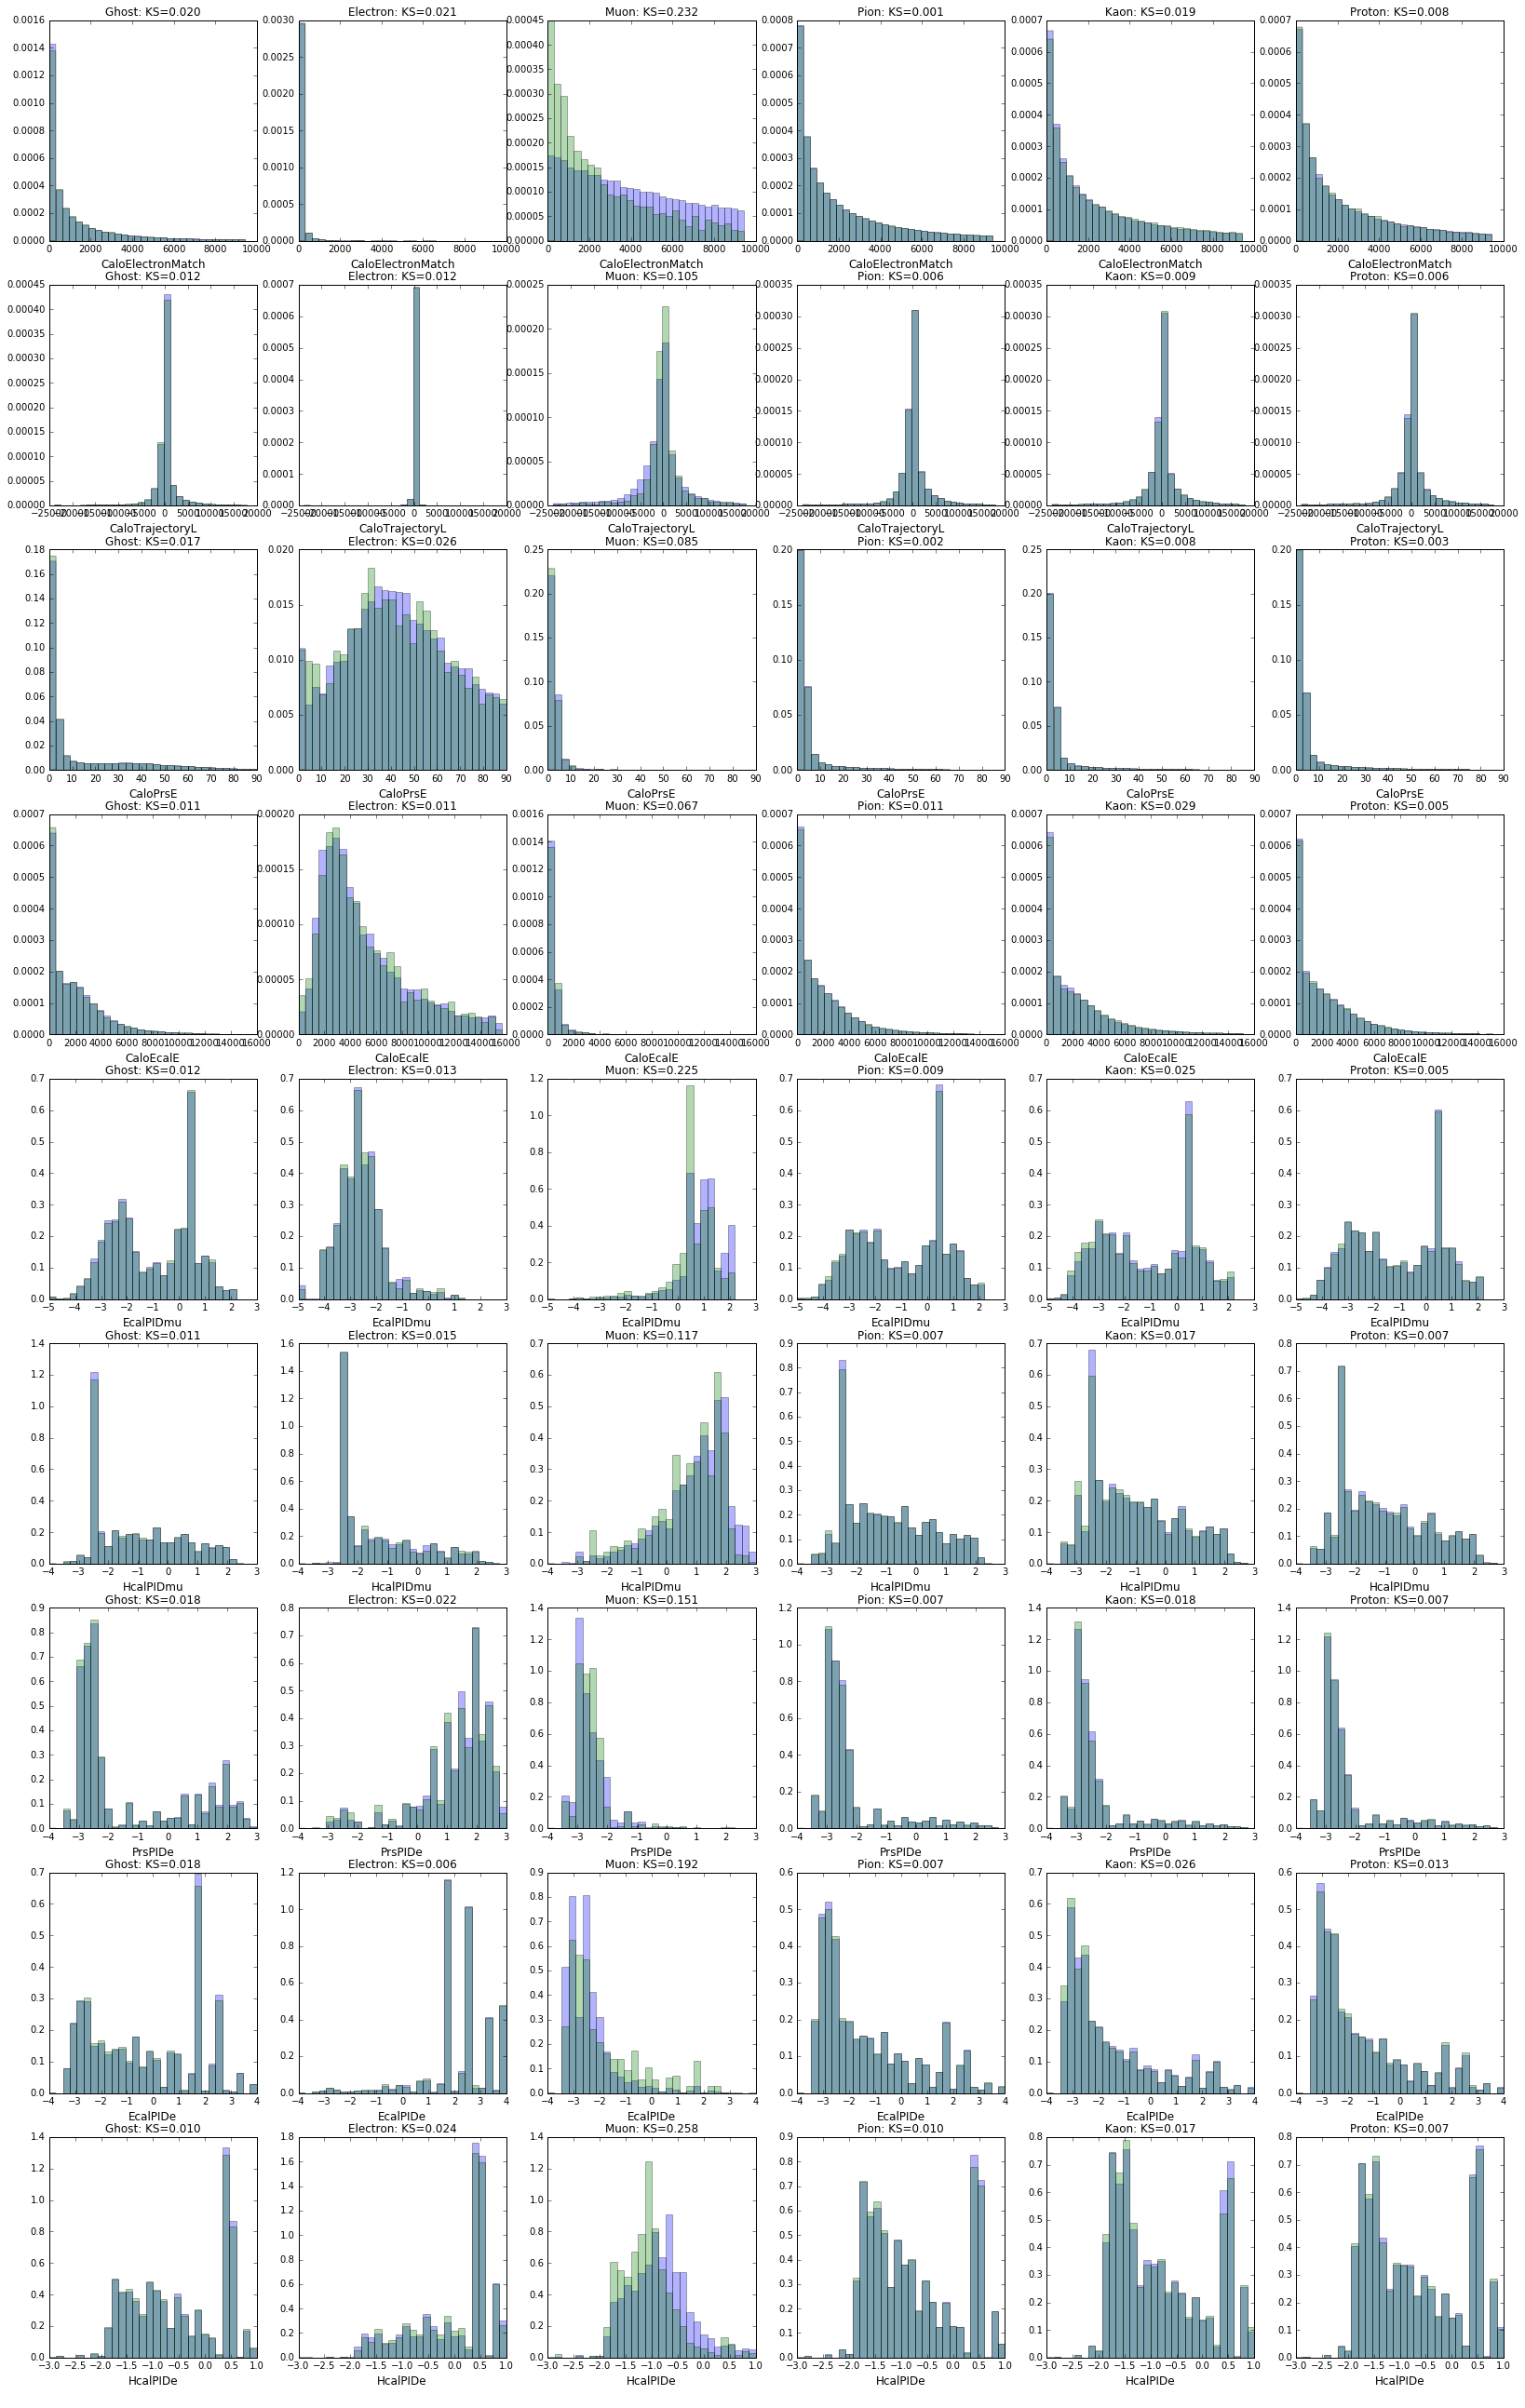

In [15]:
compare_data_by_particle(data1, data2, features_CALO_plot)
plt.savefig(os.path.join(model_output, 'two_files_comparison_calo.pdf'), format='pdf')

## RICH features

In [16]:
features_RICH_DLL = filter(lambda x: 'RichDLL' in x, data1.columns)
features_RICH_gas = ['RichUsedR1Gas', 'RichUsedR2Gas']
features_RICH_above = filter(lambda x: 'RichAbove' in x, data1.columns)
features_RICH = features_RICH_above + features_RICH_gas + features_RICH_DLL

In [17]:
features_RICH_plot = [
 'RichAbovePiThres',
 'RichAbovePrThres',
 'RichAboveKaThres',
 'RichUsedR2Gas',
 'RichDLLbt',
 'RichDLLmu',
 'RichDLLk',
 'RichDLLe',
 'RichDLLp']

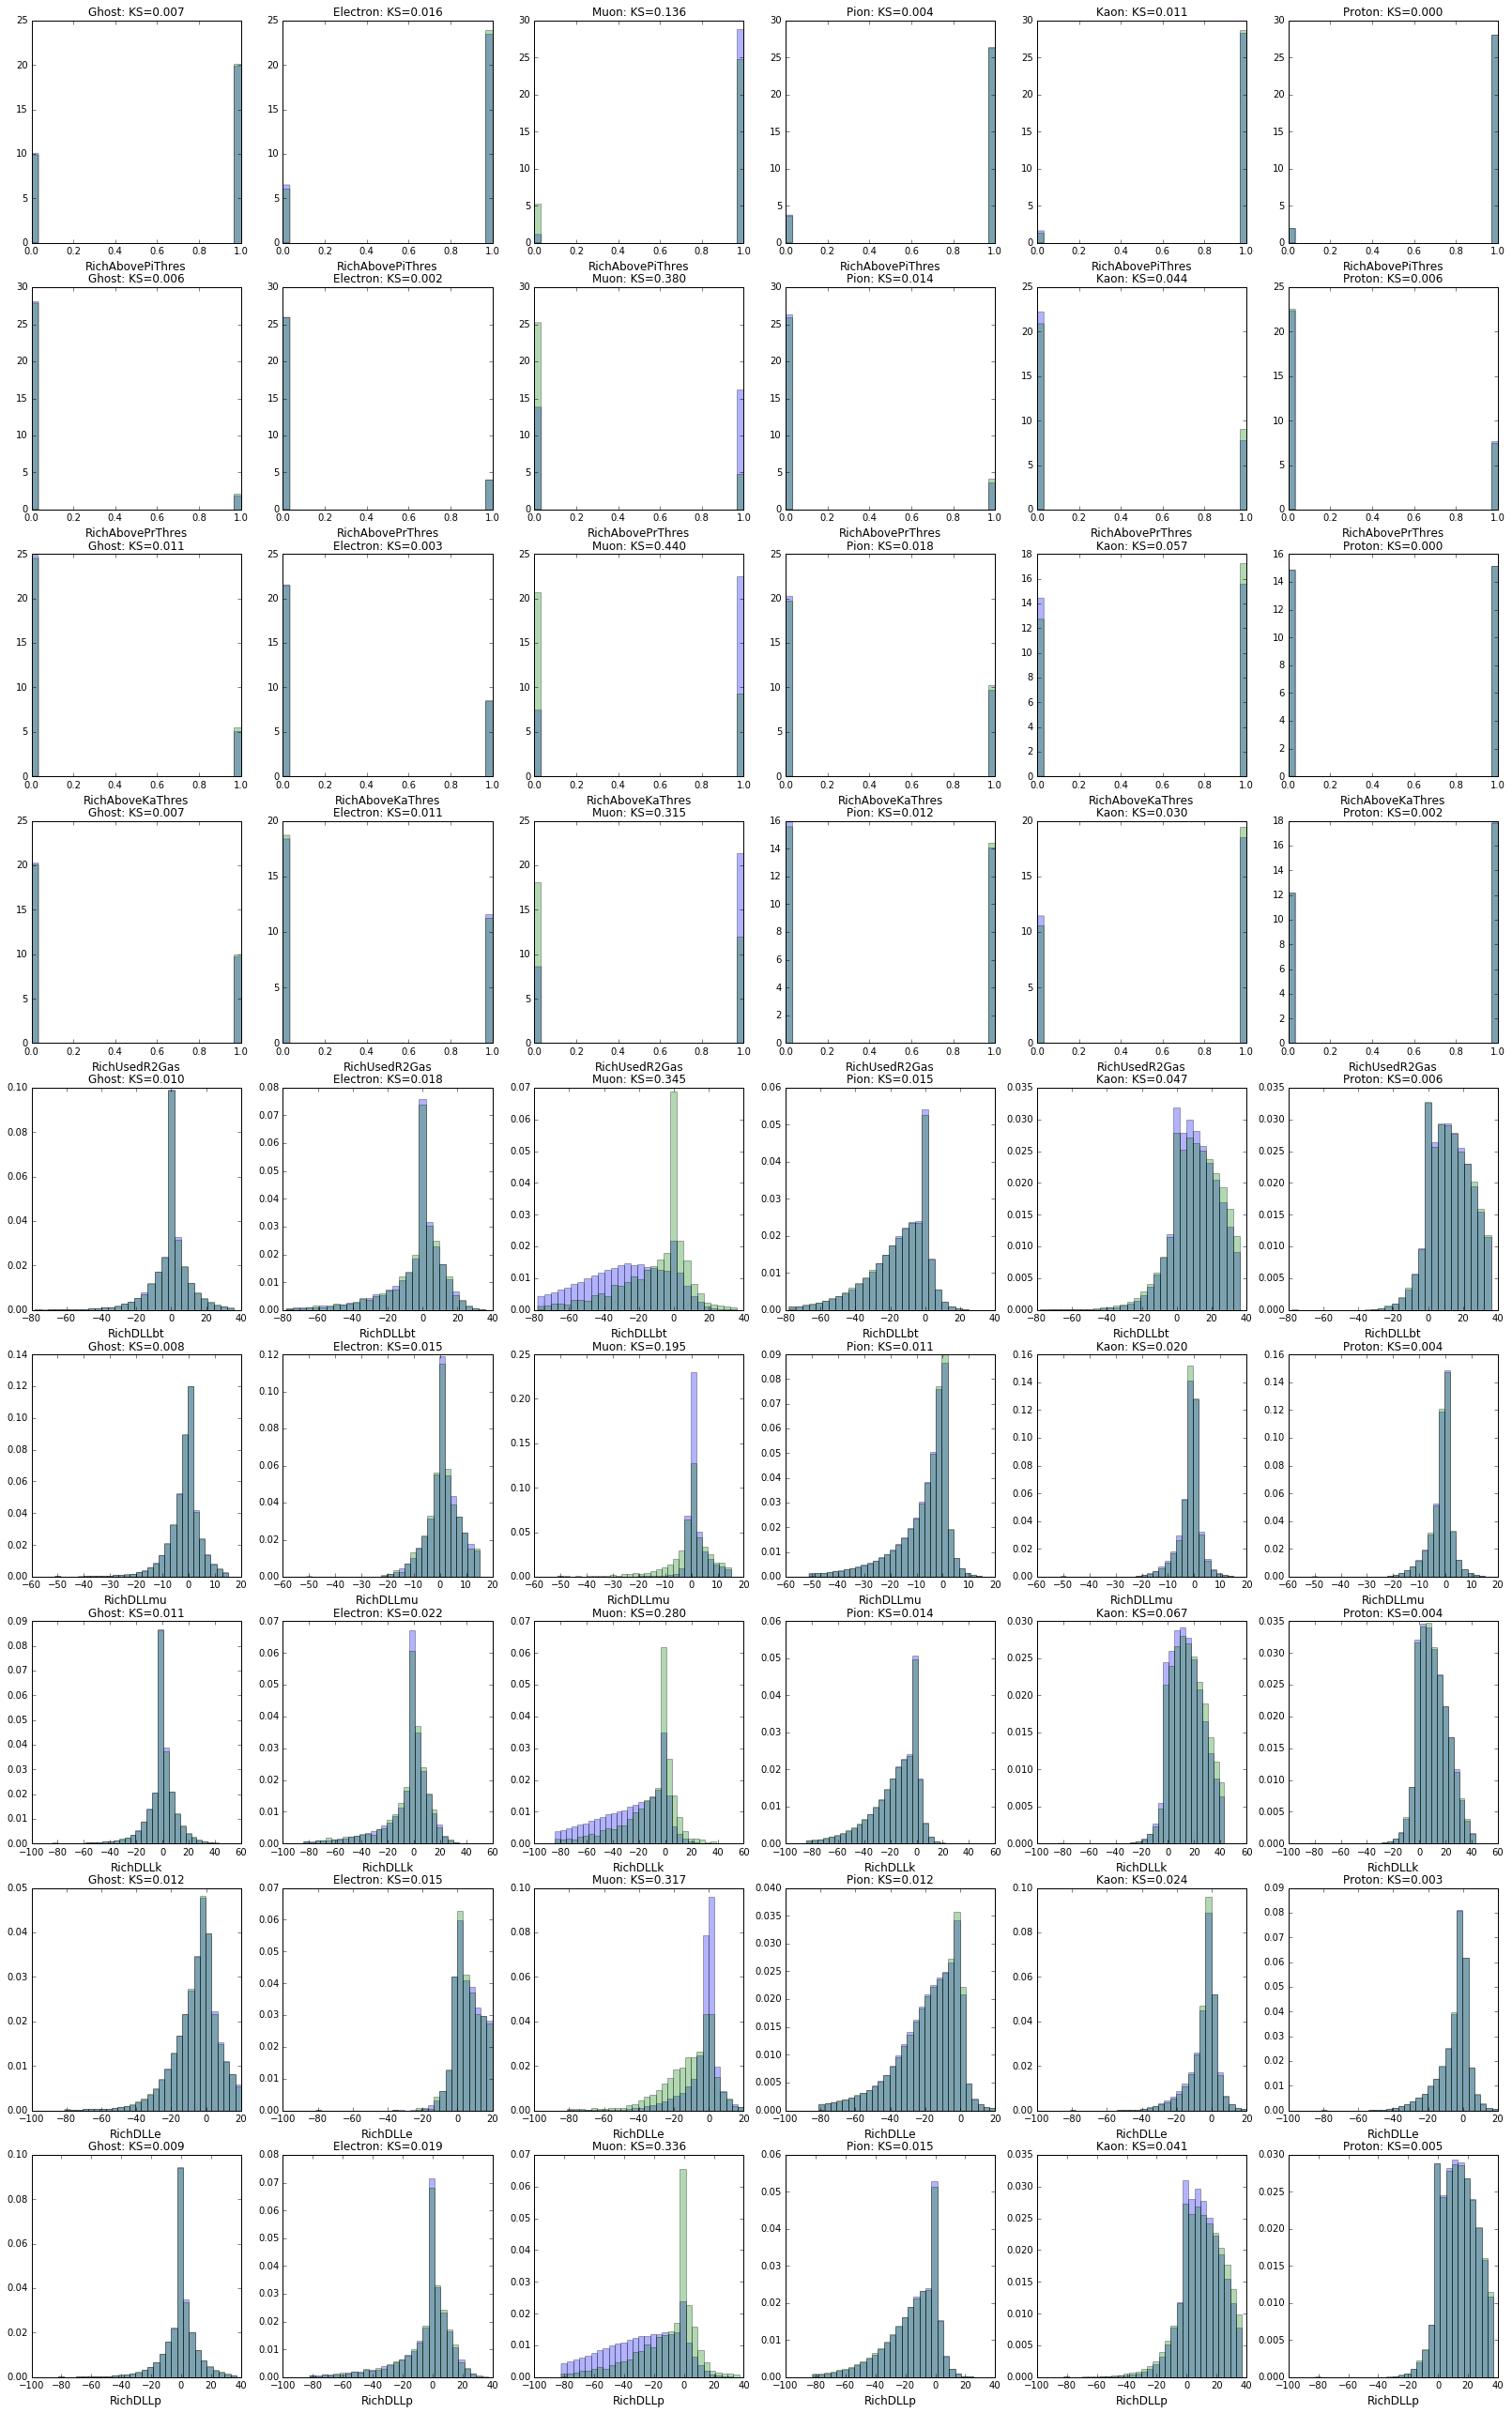

In [18]:
compare_data_by_particle(data1, data2, features_RICH_plot)
plt.savefig(os.path.join(model_output, 'two_files_comparison_rich.pdf'), format='pdf')

## COMBO DLL features

In [19]:
features_Comb_DLL = filter(lambda x: 'CombDLL' in x, data1.columns)

In [20]:
features_Comb_DLL_plot = ['CombDLLmu', 'CombDLLe', 'CombDLLk', 'CombDLLp']

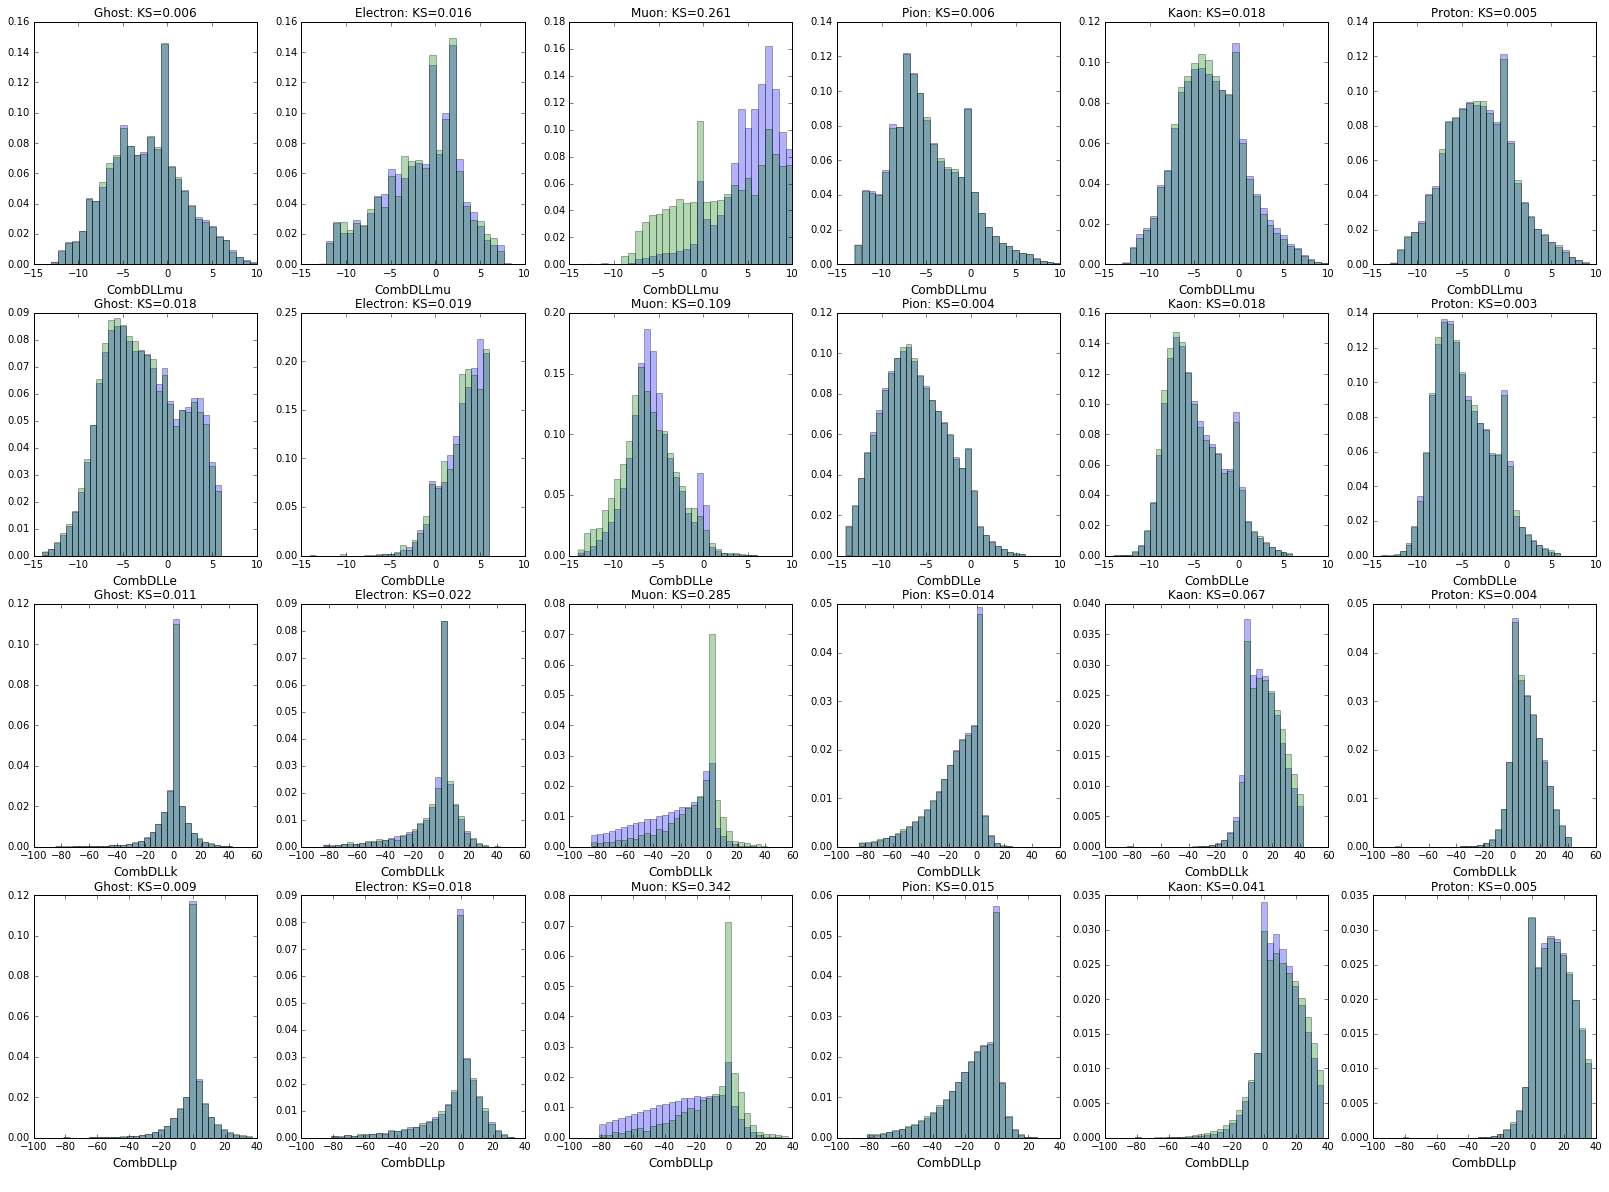

In [21]:
compare_data_by_particle(data1, data2, features_Comb_DLL_plot)
plt.savefig(os.path.join(model_output, 'two_files_comparison_combo.pdf'), format='pdf')

## Track features

In [22]:
features_track = filter(lambda x: 'Track' in x, data1.columns) 
features_track = list(set(features_track) - {'TrackMatchChi2', 'TrackCloneDist', 'TrackType', 'TrackLikelihood',
                                             'NumMuonTracks', 'NumDownstreamTracks', 'NumLongTracks', 'NumVeloTracks',
                                             'NumUpstreamTracks', 'NumTTracks', 'TrackHistory', })

In [23]:
features_track_plot = ['TrackFitVeloChi2',
 'TrackFitVeloNDoF',
 'TrackFitMatchChi2',
 'TrackChi2PerDof',
 'TrackGhostProbability',
 'TrackP',
 'TrackFitTNDoF',
 'TrackFitTChi2',
 'TrackPt',
 'TrackNumDof']

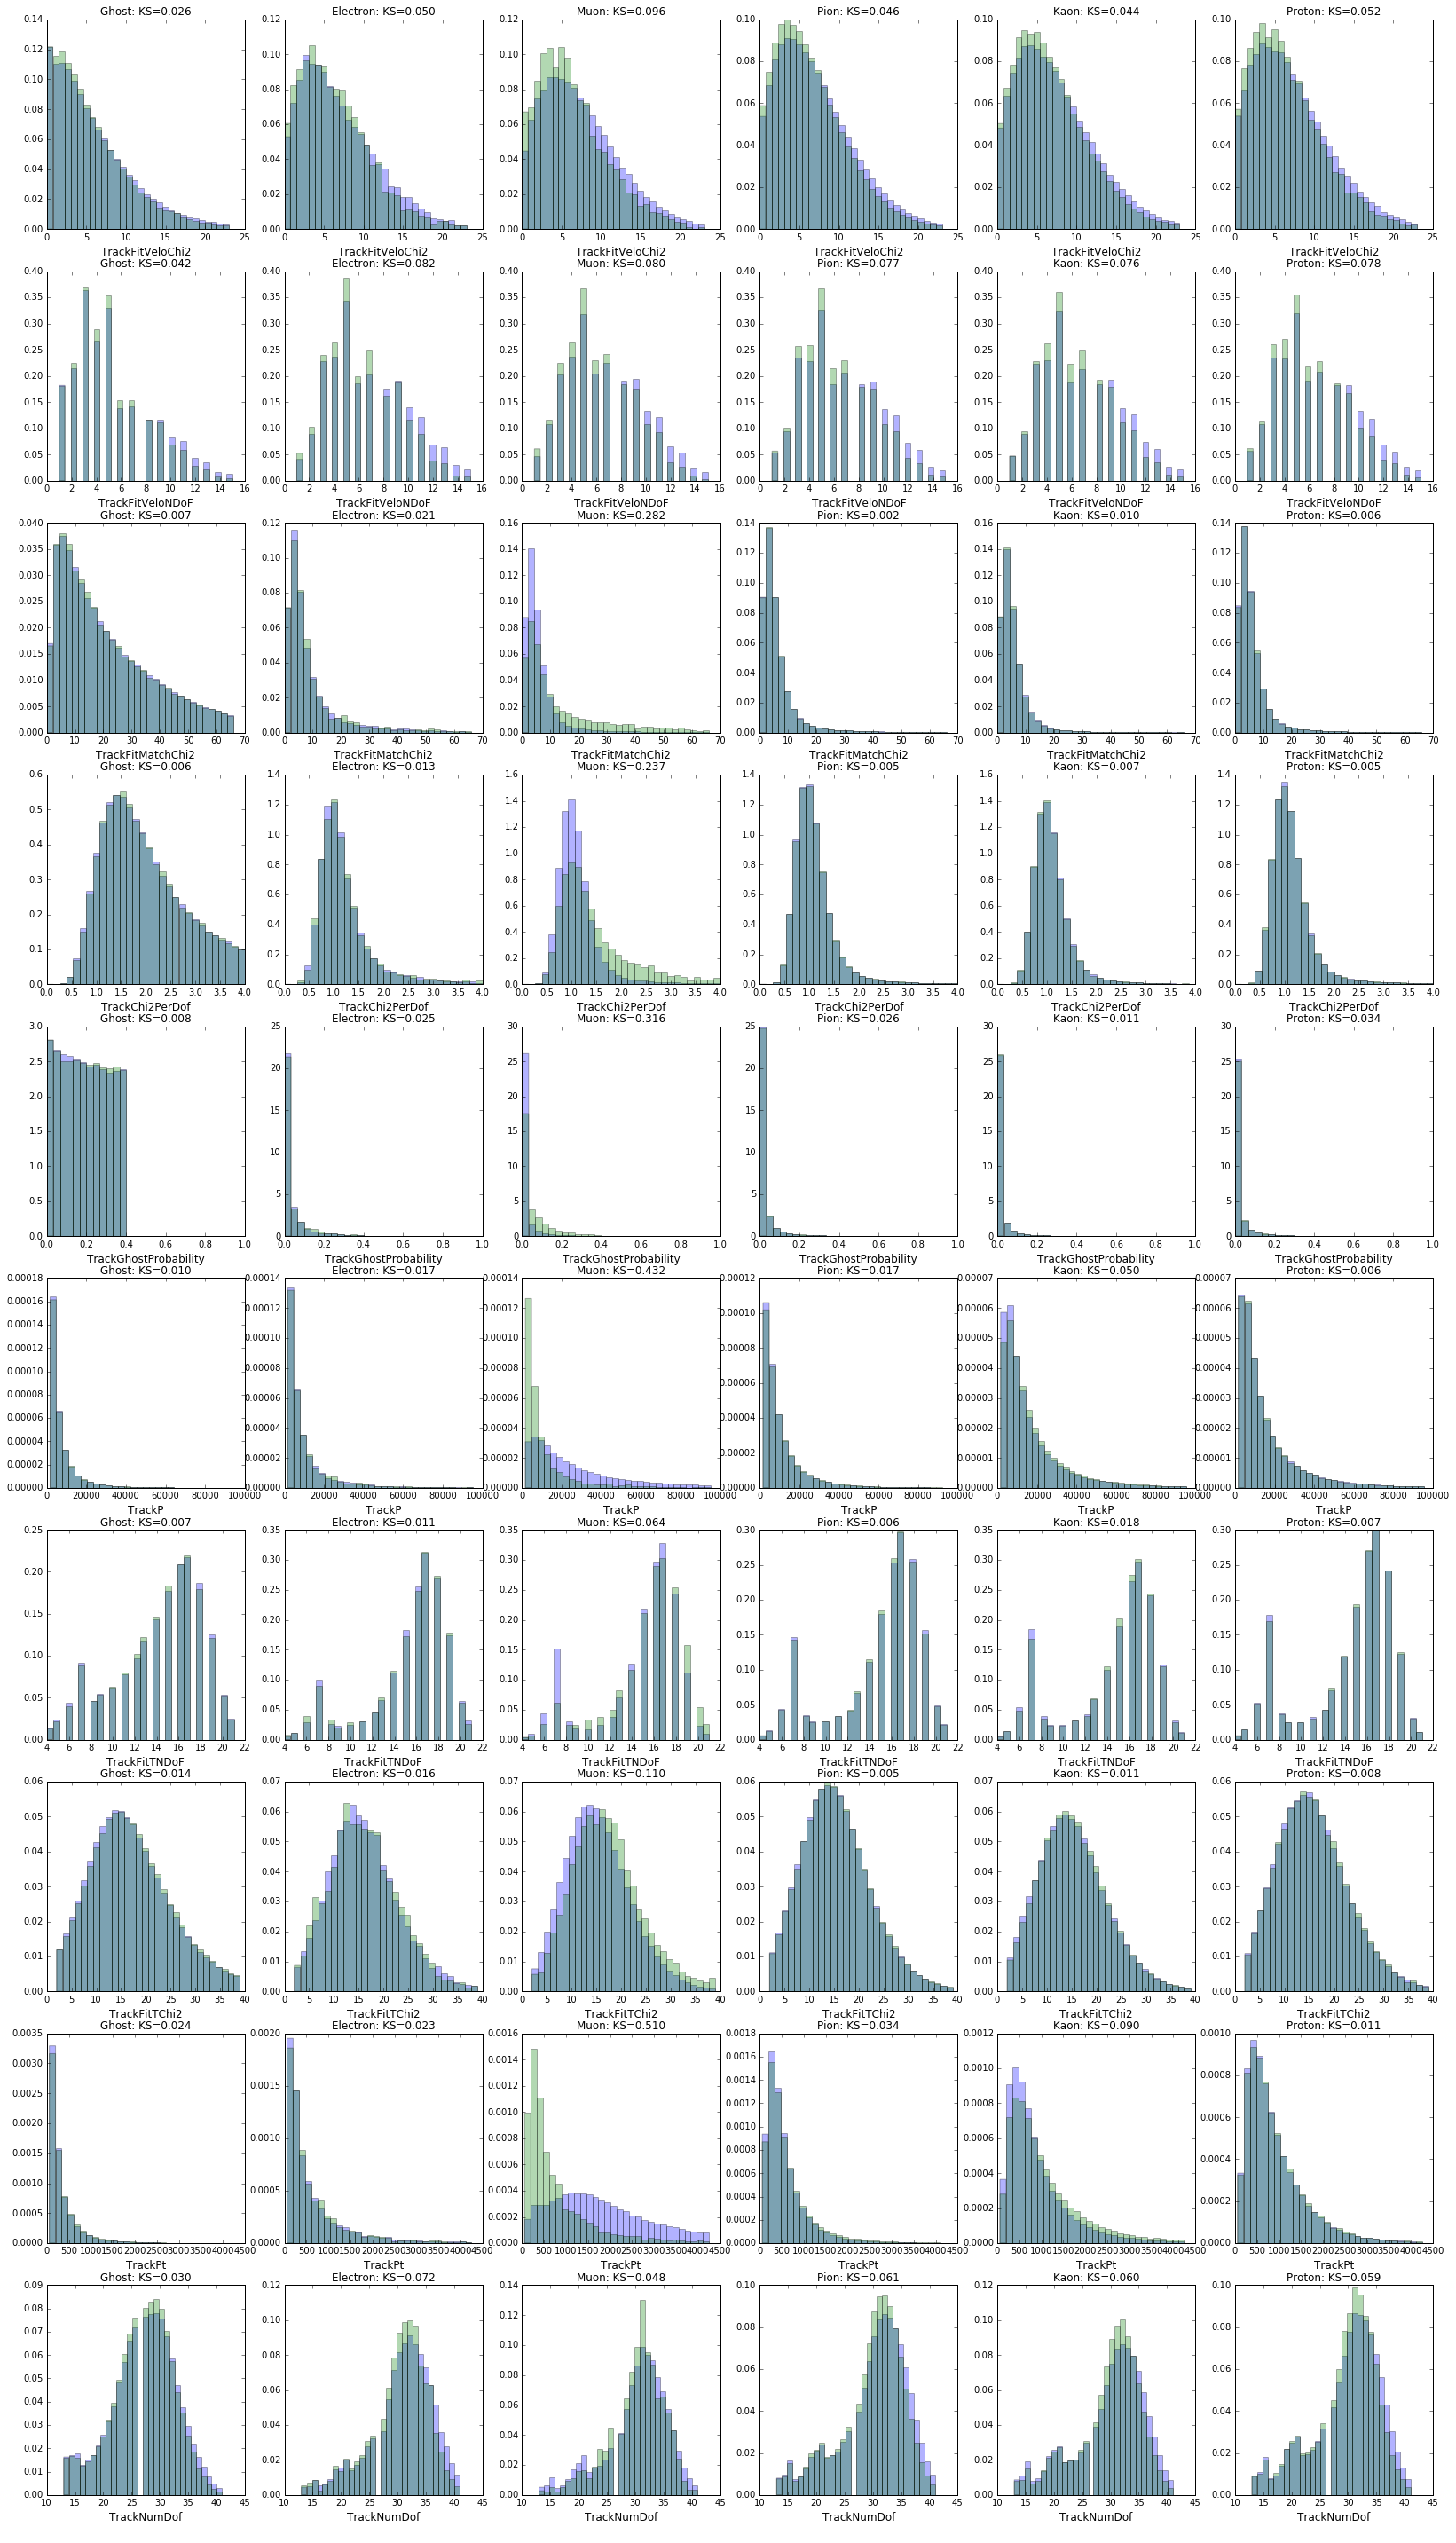

In [24]:
compare_data_by_particle(data1, data2, features_track_plot)
plt.savefig(os.path.join(model_output, 'two_files_comparison_track.pdf'), format='pdf')

## Muon features

In [25]:
features_muon = ['MuonNShared', 'MuonIsLooseMuon', 'MuonIsMuon', 'MuonBkgLL', 'MuonMuLL'] 

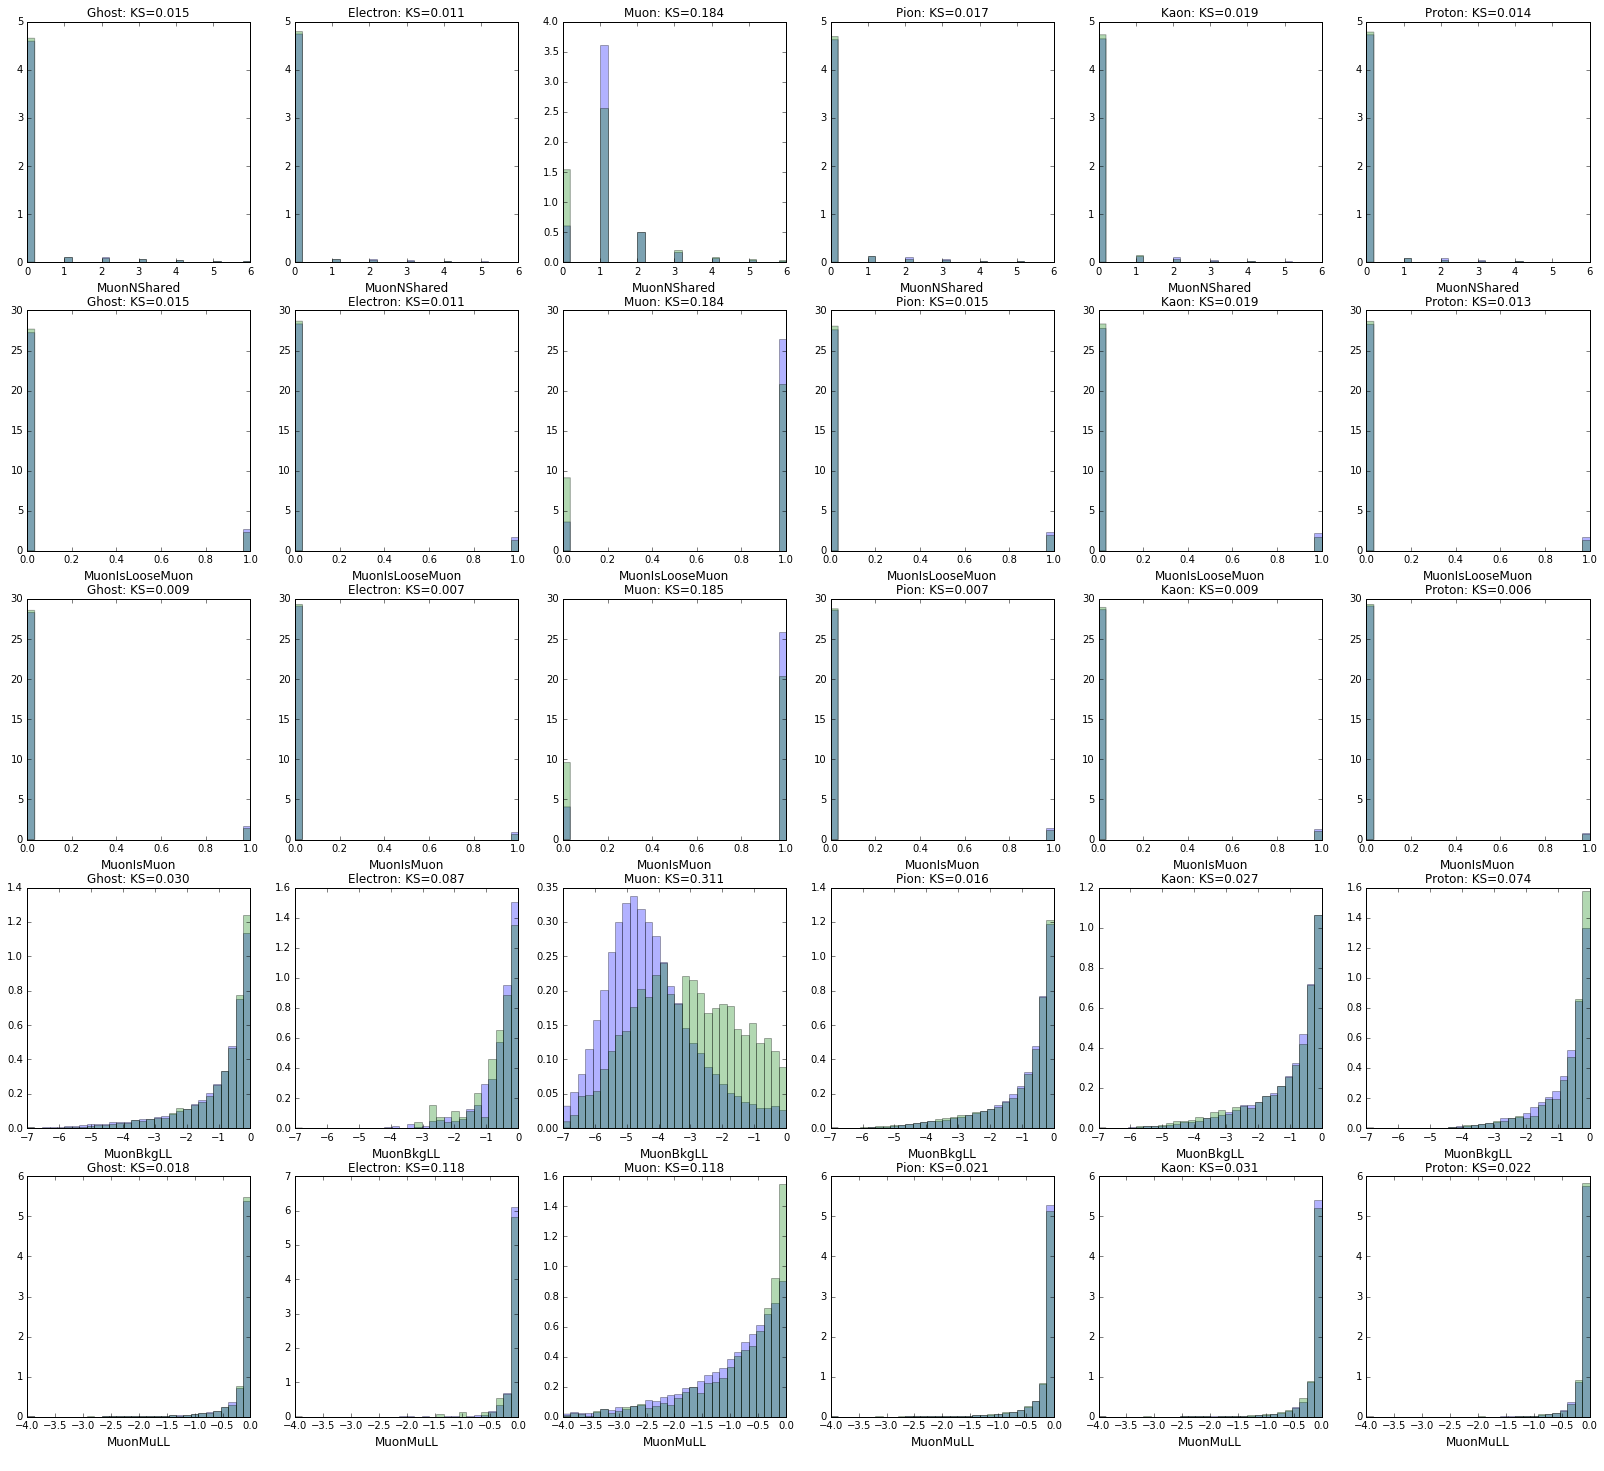

In [26]:
compare_data_by_particle(data1, data2, features_muon)
plt.savefig(os.path.join(model_output, 'two_files_comparison_muon.pdf'), format='pdf')

# Train, test splitting

In [27]:
from sklearn.cross_validation import train_test_split
joined_data = pandas.concat([data1, data2], axis=0)
joined_data['file_id'] = numpy.array([0] * len(data1) + [1] * len(data2))

In [28]:
print len(data1), len(data2)

2415204 495694


# Train the classifier to distinguish tracks of type X (data1) from tracks of type X (data2).

This is a way to compare multidimensional distibutions. 

If classifier cannot distinguish one sample from another sample then it cannot use information that samples have different multidimensional distributions. In case of MC/data disagreement classifier should not distinguish MC and data. The AUC score should be ~ 0.5 in the ideal case when multidimensional distributions coincide.

In [29]:
features_original = features_acceptance + features_CALO + features_RICH + features_Comb_DLL + features_track + features_muon

In [30]:
len(features_original)

60

In [31]:
print features_original

['InAccSpd', 'InAccPrs', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon', 'CaloBremMatch', 'CaloElectronMatch', 'CaloTrMatch', 'CaloTrajectoryL', 'CaloChargedSpd', 'CaloChargedPrs', 'CaloChargedEcal', 'CaloNeutralSpd', 'CaloNeutralPrs', 'CaloNeutralEcal', 'CaloSpdE', 'CaloPrsE', 'CaloEcalE', 'CaloHcalE', 'EcalPIDmu', 'HcalPIDmu', 'PrsPIDe', 'BremPIDe', 'EcalPIDe', 'HcalPIDe', 'RichAboveElThres', 'RichAbovePiThres', 'RichAbovePrThres', 'RichAboveKaThres', 'RichAboveMuThres', 'RichUsedR1Gas', 'RichUsedR2Gas', 'RichDLLbt', 'RichDLLmu', 'RichDLLpi', 'RichDLLk', 'RichDLLe', 'RichDLLp', 'CombDLLpi', 'CombDLLmu', 'CombDLLe', 'CombDLLk', 'CombDLLp', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitMatchChi2', 'TrackChi2PerDof', 'TrackGhostProbability', 'TrackP', 'TrackFitTNDoF', 'TrackFitTChi2', 'TrackPt', 'TrackNumDof', 'TrackDOCA', 'MuonNShared', 'MuonIsLooseMuon', 'MuonIsMuon', 'MuonBkgLL', 'MuonMuLL']


In [32]:
from decisiontrain import DecisionTrainClassifier
from rep.metaml import FoldingClassifier
from rep.report.metrics import RocAuc

In [33]:
train_data, test_data = train_test_split(joined_data, train_size=0.51, random_state=19)

## Train DT classifier for each type of tracks

In [34]:
def compare_ndimensional_distributions(test_data, features, reweighters=None, iterations=30):
    result = ""
    aucs_all = {}
    plt.figure(figsize=(30, 3))
    for label, particle_name in labels_names_correspondence.items():
        subplot(1, 6, label + 1)
        aucs = []
        for i in range(iterations):
            dt_p = DecisionTrainClassifier(n_estimators=1000, depth=6, learning_rate=0.1, n_threads=12)
            dt_p = FoldingClassifier(dt_p, features=features, n_folds=2)

            particle_data = test_data[test_data.Signal == label]
            weights = numpy.ones(len(particle_data)) 
            if reweighters is not None: 
                weights = reweighters[label].predict_weights(particle_data[features])
                weights[particle_data['file_id'].values == 1] = 1.
            
            dt_p.fit(particle_data, particle_data['file_id'], sample_weight=weights)
            report = dt_p.test_on(particle_data, particle_data['file_id'], sample_weight=weights)
            aucs.append(report.compute_metric(RocAuc())['clf'])
        report.learning_curve(RocAuc(), steps=1).plot()
        legend(loc='lower right')
        legend([particle_name])
        result += "{:10}".format(particle_name) + ' discrimination : %1.5f +/- %1.5f \n' \
            %(numpy.mean(aucs), numpy.std(aucs))
        aucs_all[particle_name] = (numpy.mean(aucs), numpy.std(aucs))
    print '-----------------------------------'
    print result
    return aucs_all

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds

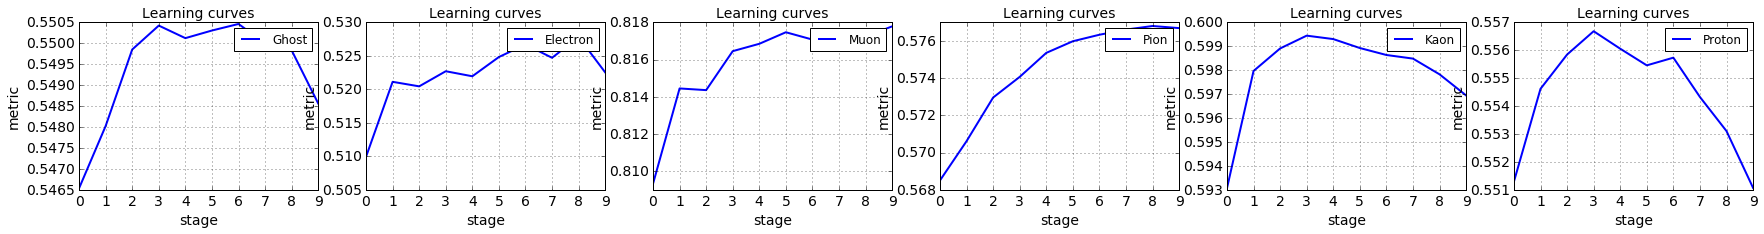

In [35]:
aucs = compare_ndimensional_distributions(test_data, features_original)

In [36]:
aucs

{'Electron': (0.51882966002176778, 0.0080698790811703797),
 'Ghost': (0.54762883212827296, 0.0012077647074286376),
 'Kaon': (0.59691053311430753, 0.00092038028599426792),
 'Muon': (0.82120435794064006, 0.0015310970179354087),
 'Pion': (0.57704300290416355, 0.00031255764847590035),
 'Proton': (0.5512169959463038, 0.0024241021334175201)}

## Remark 

Quality should be 0.5, which means that classifier cannot distinguish one sample from another. 

In our case muons are very different in these two datasets. Other particles also have significant difference (except electrons).

# Reweight multidimensional distributions using [GB reweighter](http://indico.cern.ch/event/397113/contributions/1837841/attachments/1213955/1771752/ACAT2016-reweighting.pdf)

reweighting data1 to data2

In [37]:
from hep_ml.reweight import GBReweighter

In [38]:
reweighters = {}
for label, particle_name in labels_names_correspondence.items():
    gb = GBReweighter(n_estimators=100, learning_rate=0.1, min_samples_leaf=2000,
                      gb_args={'subsample': 0.5, 'random_state': 11})
    data_particle = train_data[train_data.Signal == label]
    gb.fit(data_particle.loc[data_particle['file_id'] == 0, features_original], 
           data_particle.loc[data_particle['file_id'] == 1, features_original])
    reweighters[label] = gb

#### Plot predicted weights to check there are no big values

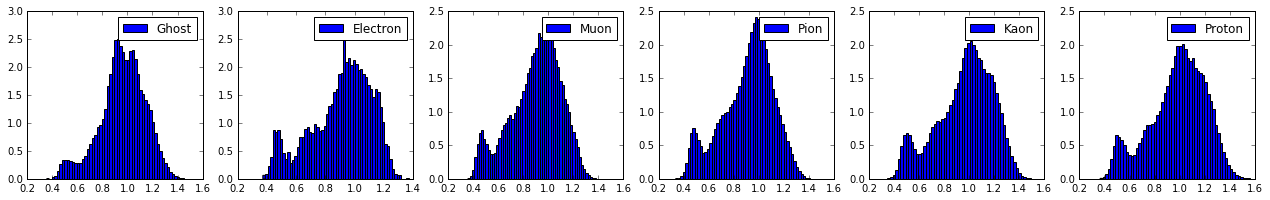

In [39]:
plt.figure(figsize=(22, 3))
for label, particle_name in labels_names_correspondence.items():
    plt.subplot(1, 6, label + 1)
    mask = (test_data.Signal == label) & (test_data['file_id'] == 0)
    data_particle_for_weights = test_data.loc[mask, features_original]
    weights = gb.predict_weights(data_particle_for_weights)
    plt.hist(weights, bins=60, normed=True, label=particle_name)
    plt.legend()

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds

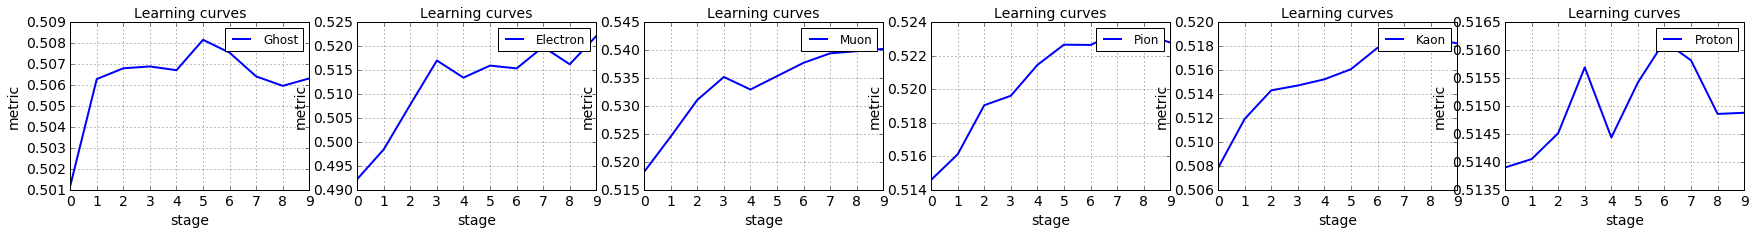

In [40]:
aucs_reweighted = compare_ndimensional_distributions(test_data, features_original, reweighters=reweighters)

In [41]:
aucs_reweighted

{'Electron': (0.51753966466096268, 0.010087397589924),
 'Ghost': (0.50996192835324805, 0.0021868365890687171),
 'Kaon': (0.51481302431485099, 0.0015998717421930465),
 'Muon': (0.54240977068435969, 0.005387666876763327),
 'Pion': (0.52286520204671916, 0.0010578229361119238),
 'Proton': (0.51301748245035927, 0.0024685694691032331)}

## Conclusion

One can notice that AUC score now is closer to 0.5 than before the reweighting. Thus reweighting works well.